# Hypothesis

Dimensions with high saliencies significantly contribute to performance of VespaG.

## Experiment

Bin dimensions based on percentiles of the distribution of the average saliencies. For each bin, set the embeddings of the corresponding dimensions to zero. Test how setting these dimensions to zero influences the performance of VespaG. Evaluate this by considering the spearman correlation between the VespaG and Gemme scores. 

## Using ProteinGym166

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from tqdm import tqdm

import sys 
sys.path.append('../vespag')

from parse.vep_scores import get_vespag_scores, get_gemme_scores

### Pipeline using ProteinGym166

#### Load Saliencies

In [3]:
wildtype_dimension = 0
mutant_dimension = 1
embeddings_dimension = 2

In [8]:
saliency_folder = '/mnt/f/nicole/proteingym_166_saliency/'

mean_array = np.zeros((2560,)) 
files = [file for file in os.listdir(saliency_folder) if file.endswith('.npy')]

# load each numpy object in the saliency folder 
for file in tqdm(files, unit='file', desc="Loading saliencies"):
    id = file.split('.npy')[0]
    saliency = np.load(os.path.join(saliency_folder, file))
    # take the absolute values of the saliencies
    saliency = np.abs(saliency)
    # reduce the saliency to the average per embedding dimension 
    mean_saliency_per_dim = saliency.mean(axis=(wildtype_dimension, mutant_dimension)) # (2560,)

    # calculate the sem of the saliency
    sem_saliency_per_dim = np.std(saliency, axis=(wildtype_dimension, mutant_dimension)) / np.sqrt(saliency.shape[wildtype_dimension] * saliency.shape[mutant_dimension])
    mean_array += mean_saliency_per_dim

mean_array /= len(files)

Loading saliencies: 100%|██████████| 166/166 [08:19<00:00,  3.01s/file]


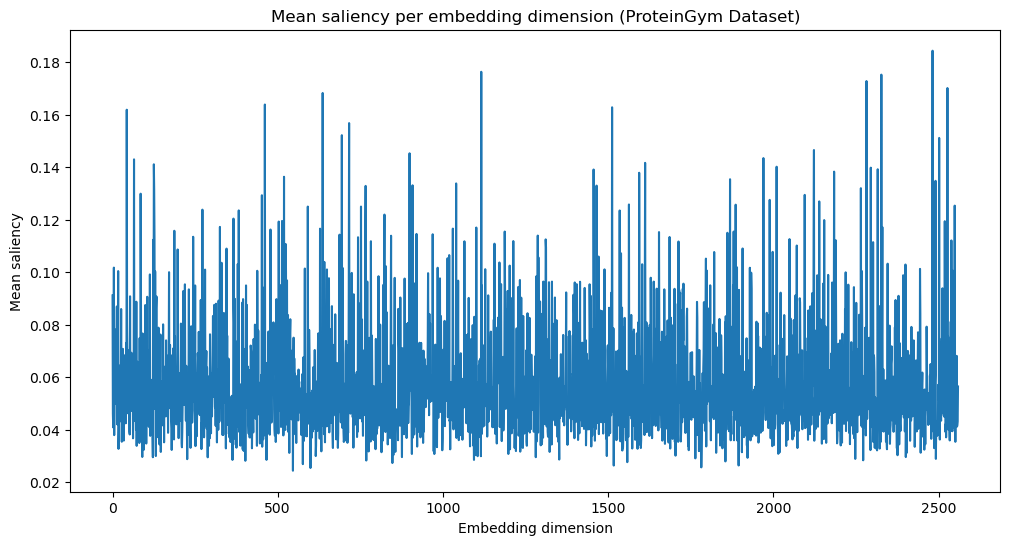

In [10]:
# plot the mean saliency for each embedding dimension
plt.figure(figsize=(12, 6))
plt.plot(mean_array, label="Mean")
plt.title("Mean saliency per embedding dimension (ProteinGym Dataset)")
plt.xlabel("Embedding dimension")
plt.ylabel("Mean saliency")
plt.show()

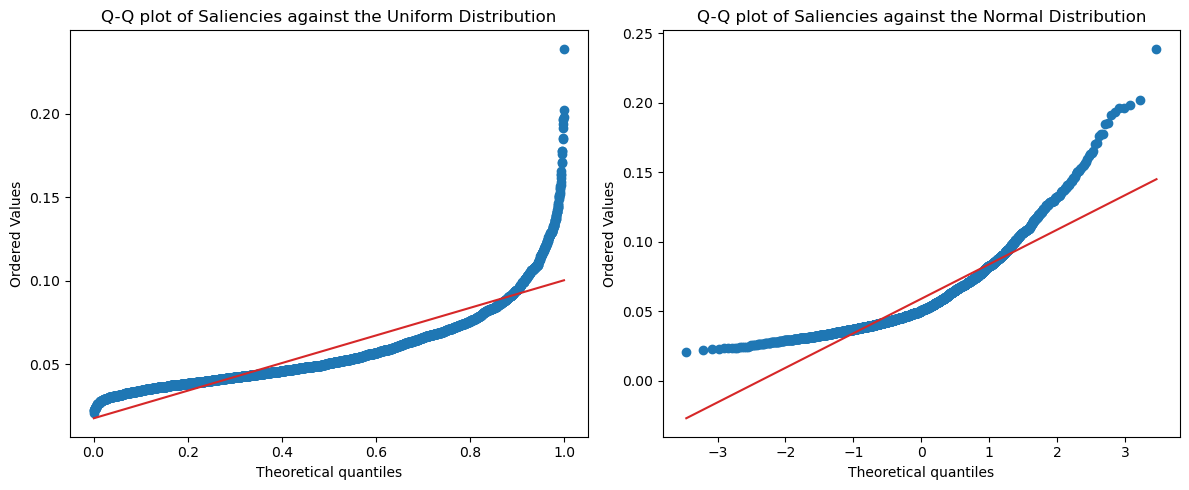

In [13]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot against the **Uniform Distribution**
stats.probplot(mean_saliency_per_dim, dist="uniform", plot=axes[0])
axes[0].get_lines()[0].set_color("tab:blue") 
axes[0].get_lines()[1].set_color("tab:red")
axes[0].set_title("Q-Q plot of Saliencies against the Uniform Distribution")

# Q-Q plot against the **Normal Distribution**
stats.probplot(mean_saliency_per_dim, dist="norm", plot=axes[1])
axes[1].get_lines()[0].set_color("tab:blue")
axes[1].get_lines()[1].set_color("tab:red")
axes[1].set_title("Q-Q plot of Saliencies against the Normal Distribution")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [14]:
# Define percentiles
percentiles = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
percentile_values = np.percentile(mean_saliency_per_dim, percentiles)

c = 0  
bins = {}  

for i in range(len(percentiles) - 1):
    lower_bound = percentile_values[i]
    upper_bound = percentile_values[i + 1]

    # Find indices of elements within this percentile range
    bin_indices = np.where((mean_saliency_per_dim >= lower_bound) & (mean_saliency_per_dim < upper_bound))[0]
    bins[f"{percentiles[i]}-{percentiles[i+1]}"] = bin_indices 

    num_dims = len(bin_indices)
    c += num_dims
    
    print(f"Number of dimensions in {percentiles[i]}-{percentiles[i+1]}th percentile: {num_dims}")

# Last bin
bin_indices_last = np.where(mean_saliency_per_dim >= percentile_values[-1])[0]
bins[f"{percentiles[-1]}-100"] = bin_indices_last 

num_dims_last = len(bin_indices_last)
c += num_dims_last

print(f"Number of dimensions in {percentiles[-1]}-100th percentile: {num_dims_last}")
assert c == mean_saliency_per_dim.shape[0], "Error: Total count does not match!"

Number of dimensions in 0-5th percentile: 128
Number of dimensions in 5-10th percentile: 128
Number of dimensions in 10-15th percentile: 128
Number of dimensions in 15-20th percentile: 128
Number of dimensions in 20-25th percentile: 128
Number of dimensions in 25-30th percentile: 128
Number of dimensions in 30-35th percentile: 128
Number of dimensions in 35-40th percentile: 128
Number of dimensions in 40-45th percentile: 128
Number of dimensions in 45-50th percentile: 128
Number of dimensions in 50-55th percentile: 128
Number of dimensions in 55-60th percentile: 128
Number of dimensions in 60-65th percentile: 128
Number of dimensions in 65-70th percentile: 128
Number of dimensions in 70-75th percentile: 128
Number of dimensions in 75-80th percentile: 128
Number of dimensions in 80-85th percentile: 128
Number of dimensions in 85-90th percentile: 128
Number of dimensions in 90-95th percentile: 128
Number of dimensions in 95-100th percentile: 128


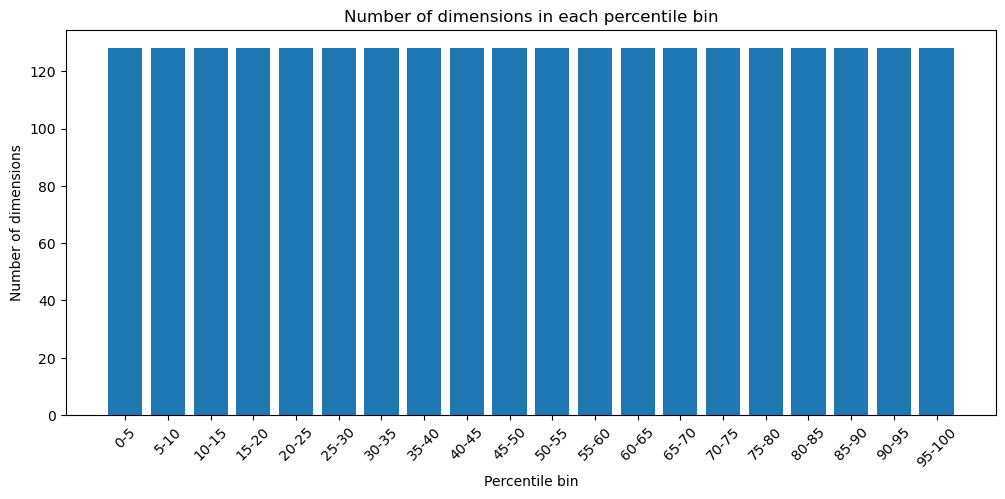

In [15]:
plt.figure(figsize=(12, 5))
plt.bar(range(len(bins)), [len(bins[k]) for k in bins.keys()])
plt.xticks(range(len(bins)), bins.keys(), rotation=45)
plt.ylabel("Number of dimensions")
plt.xlabel("Percentile bin")
plt.title("Number of dimensions in each percentile bin")
plt.show()

#### Set the embeddings of the embedding values of all of the dimensions to different values as well 

In [16]:
embedding_file = '/mnt/f/nicole/proteingym_166_vespag/esm2_embeddings.h5'
modified_values = [0, 0.25, 0.5, 0.75, 1, 1.5, 2]

modified_embeddings_folder = '/mnt/f/nicole/modified_proteingym_166_embeddings/'
os.makedirs(modified_embeddings_folder, exist_ok=True)

# Open the original h5 file
with h5py.File(embedding_file, 'r') as f:
    protein_ids = list(f.keys())

    # Iterate over each bin and modified value to create separate h5 files
    for modified_value in modified_values:
        for bin_name, bin_indices in bins.items():
            bin_name = bin_name.replace('-', '_')

            # Define output file name for this configuration
            modified_embedding_file = os.path.join(
                modified_embeddings_folder,
                f'modified_embedding_value={modified_value}_bin={bin_name}.h5'
            )

            # Create a new .h5 file for this configuration
            with h5py.File(modified_embedding_file, 'w') as f_out:
                for protein_id in tqdm(protein_ids, desc=f"Processing {bin_name} - {modified_value}"):
                    embedding = torch.tensor(f[protein_id][()])  
                    
                    modified_embedding = embedding.clone()
                    modified_embedding[:, bin_indices] = modified_value  

                    # Store the modified embedding under the protein ID
                    f_out.create_dataset(protein_id, data=modified_embedding.numpy())

print("All modified embeddings have been stored in separate configuration files.")

Processing 95_100 - 2: 100%|██████████| 166/166 [00:08<00:00, 19.54it/s]


All modified embeddings have been stored in separate configuration files.


#### Off screen: Generate VespaG predictions for these bins for ProteinGym 166

#### Load the original and modified VespaG results and the Gemme results

In [17]:
from parse.vep_scores import load_vespag_scores_from_folder, load_gemme_scores_from_folder

Because of memory restrictions we cannot load all VespaG results at once and then calculate the correlations etc. We have to load one batch of VespaG results and then reduce to the correlation towards the gemme results right away.

In [18]:
# load the original vespag results 
vespag_path = '/mnt/f/nicole/proteingym_166_vespag/'
original_vespag_result = load_vespag_scores_from_folder(vespag_path)
original_vespag_result['mutation_effect'] = - original_vespag_result['vespag']
original_vespag_result['original_vespag'] = (original_vespag_result['mutation_effect'] - original_vespag_result['mutation_effect'].min()) / (original_vespag_result['mutation_effect'].max() - original_vespag_result['mutation_effect'].min())

# load the gemme results 
gemme_path = '/mnt/f/nicole/proteingym_166_gemme'
gemme_scores = load_gemme_scores_from_folder(gemme_path)
gemme_scores['mutation_effect'] = - gemme_scores['gemme']
gemme_scores['gemme'] = (gemme_scores['mutation_effect'] - gemme_scores['mutation_effect'].min()) / (gemme_scores['mutation_effect'].max() - gemme_scores['mutation_effect'].min())

# merge the results
original_scores = pd.merge(original_vespag_result.drop(['vespag', 'mutation_effect'], axis=1), gemme_scores.drop(['mutation_effect'], axis=1), on=['id', 'residue', 'mutation'])
print(original_scores.shape, gemme_scores.shape, original_vespag_result.shape)
original_scores.head()

Loading VespaG scores:   0%|          | 0/166 [00:00<?, ?file/s]

Loading Gemme scores: 100%|██████████| 166/166 [00:05<00:00, 28.62folder/s]


(830661, 5) (830661, 5) (830661, 6)


,residue,mutation,id,original_vespag,gemme
0,T1,T1A,OTU7A_HUMAN,0.211790,0.175752
1,T1,T1Y,OTU7A_HUMAN,0.348752,0.197457
2,T1,T1W,OTU7A_HUMAN,0.373717,0.197457
3,T1,T1V,OTU7A_HUMAN,0.265046,0.197457
4,T1,T1S,OTU7A_HUMAN,0.199449,0.175752


In [19]:
# calculate the spearman correlation between the original vespag and gemme results
baseline_correlation = original_scores['original_vespag'].corr(original_scores['gemme'], method='spearman')
baseline_correlation

0.7462097124809847

In [20]:
gemme_scores.head()

,residue,mutation,gemme,id,mutation_effect
0,T1,T1A,0.247392,DNJA1_HUMAN,1.281414
1,T1,T1S,0.152055,DNJA1_HUMAN,0.198297
2,T1,T1R,0.308520,DNJA1_HUMAN,1.975876
3,T1,T1Q,0.308520,DNJA1_HUMAN,1.975876
4,T1,T1C,0.247392,DNJA1_HUMAN,1.281414


In [23]:
vespag_folders = '/mnt/f/nicole/output_proteingym_166_modified_binned/'
folders = os.listdir(vespag_folders)

correlations = []

for folder in tqdm(folders, desc="Processing folders", unit="folder"):
    # get the modified value and dimension from the folder name
    config = folder.replace("modified_embedding_", '')
    modified_value, bin = config.split('_bin=')
    bin = bin.replace('_', '-')
    modified_value = modified_value.replace('value=', '')

    vespag_scores = load_vespag_scores_from_folder(os.path.join(vespag_folders, folder))
    vespag_scores = vespag_scores.rename(columns={'vespag': 'modified_vespag'})
    vespag_scores['modified_value'] = modified_value
    vespag_scores['bin'] = bin

    # preprocessing 
    vespag_scores['modified_mutation_effect'] = - vespag_scores['modified_vespag']
    vespag_scores['modified_norm_mutational_effect'] = (vespag_scores.modified_mutation_effect - vespag_scores.modified_mutation_effect.min()) / (vespag_scores.modified_mutation_effect.max() - vespag_scores.modified_mutation_effect.min())

    # merge the gemme results
    modified_results = pd.merge(vespag_scores, gemme_scores[['id', 'residue', 'mutation', 'gemme']], on=['id', 'residue', 'mutation'])
    assert modified_results.shape[0] == vespag_scores.shape[0] and modified_results.shape[0] == gemme_scores.shape[0]

    # calculate the spearman correlation
    spearman_correlation = modified_results['modified_norm_mutational_effect'].corr(modified_results['gemme'], method='spearman')
    spearman_correlation = abs(spearman_correlation)

    # store the results
    correlations.append({
        'bin': bin,
        'modified_value': modified_value,
        'spearman_correlation': spearman_correlation
    })

correlations = pd.DataFrame(correlations)
correlations.head()

Processing folders: 100%|██████████| 140/140 [15:38<00:00,  6.70s/folder]


,bin,modified_value,spearman_correlation
0,85-90,0,0.737168
1,90-95,0,0.728588
2,95-100,0,0.670916
3,5-10,0.5,0.711902
4,10-15,0.5,0.749651


In [24]:
correlations['lower_bound'] = correlations['bin'].apply(lambda x: int(x.split('-')[0]))
correlations.head()

,bin,modified_value,spearman_correlation,lower_bound
0,85-90,0,0.737168,85
1,90-95,0,0.728588,90
2,95-100,0,0.670916,95
3,5-10,0.5,0.711902,5
4,10-15,0.5,0.749651,10


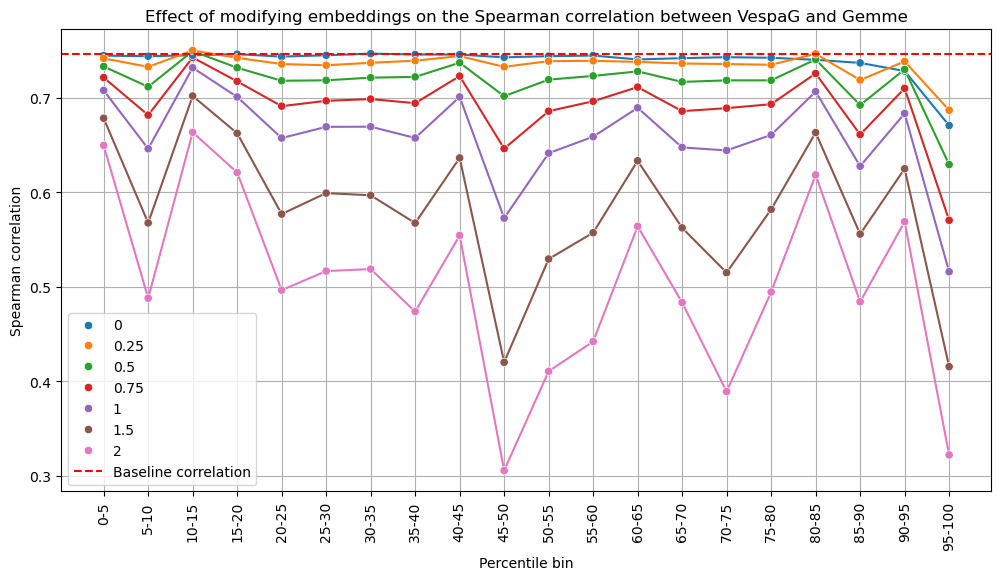

In [25]:
correlations['lower_bound'] = correlations['bin'].apply(lambda x: int(x.split('-')[0]))
correlations = correlations.sort_values('lower_bound')

# ensure same color map as before
color_mapping = {
    '0': 'tab:blue',
    '0.25': 'tab:orange',
    '0.5': 'tab:green',
    '0.75': 'tab:red',
    '1': 'tab:purple',
    '1.5': 'tab:brown',
    '2': 'tab:pink'
}
plt.figure(figsize=(12, 6))
order = correlations.lower_bound.sort_values().index
sns.lineplot(data=correlations, x='bin', y='spearman_correlation', hue='modified_value', palette=color_mapping, zorder=2)
sns.scatterplot(data=correlations, x='bin', y='spearman_correlation', hue='modified_value', palette=color_mapping, zorder=2)
plt.axhline(y=baseline_correlation, color='r', linestyle='--', label='Baseline correlation', zorder=2)
plt.title('Effect of modifying embeddings on the Spearman correlation between VespaG and Gemme')

# Fix legend order manually to fit first plot
handles, labels = plt.gca().get_legend_handles_labels()
legend_dict = dict(zip(labels, handles))  # Remove duplicates

sorted_legend_items = sorted(
    legend_dict.items(), key=lambda x: float(x[0]) if x[0].replace('.', '', 1).isdigit() else float('inf')
)
sorted_labels, sorted_handles = zip(*sorted_legend_items)

plt.legend(sorted_handles, sorted_labels)
plt.ylabel("Spearman correlation")
plt.xlabel("Percentile bin")
plt.xticks(rotation=90)
plt.grid(zorder=0)
plt.show()

### Invert the experiment

From the PLA results we can see that especially the dimensions in the 85 percentile of the saliencies have the largest effect on the performance of VespaG. 

Now invert the experiment, meaning that I will set all other dimensions to zero and then consider the performance of VespaG. 



In [26]:
# select the 85 quantile of the saliencies 
q85 = np.percentile(mean_saliency_per_dim, 85)
dimensions = np.where(mean_saliency_per_dim >= q85)[0]
modify_dimensions = np.where(mean_saliency_per_dim < q85)[0]
assert len(modify_dimensions) + len(dimensions) == mean_saliency_per_dim.shape[0]

In [27]:
embedding_file = '/mnt/f/nicole/proteingym_166_vespag/esm2_embeddings.h5' 
modified_embeddings_folder = '/mnt/f/nicole/modified_inverted_embeddings_proteingym_166/'
os.makedirs(modified_embeddings_folder, exist_ok=True)

modified_value = 0

percentiles = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 99]

for percentile in tqdm(percentiles, desc="Processing percentiles"):

    # quantile value
    q = np.percentile(mean_saliency_per_dim, percentile)
    modify_dimensions = np.where(mean_saliency_per_dim < q)[0]

    # open the original h5 file
    with h5py.File(embedding_file, 'r') as f:
        protein_ids = list(f.keys())

        # define output file name for this configuration
        modified_embedding_file = os.path.join(
            modified_embeddings_folder,
            f'modified_embedding_value={modified_value}_q{percentile}.h5'
        )

        # create a new .h5 file for this configuration
        with h5py.File(modified_embedding_file, 'w') as f_out:
            for protein_id in tqdm(protein_ids, desc=f"Processing proteins"):
                embedding = torch.tensor(f[protein_id][()])  

                modified_embedding = embedding.clone()
                modified_embedding[:, modify_dimensions] = modified_value  

                # store the modified embedding under the protein ID
                f_out.create_dataset(protein_id, data=modified_embedding.numpy())


Processing percentiles: 100%|██████████| 20/20 [04:44<00:00, 14.20s/it]


#### Off Screen: Generate VespaG predictions

#### Load the results

In [28]:
# load the results 
vespag_folders = '/mnt/f/nicole/output_proteingym_166_modified_inverted'
folders = os.listdir(vespag_folders)

correlations_zero = []

for folder in tqdm(folders, desc="Processing folders", unit="folder"):
    # get the modified value and dimension from the folder name
    config = folder.replace("modified_embedding_", '')
    modified_value, percentile = config.split('_q')
    modified_value = modified_value.replace('value=', '')

    vespag_scores = load_vespag_scores_from_folder(os.path.join(vespag_folders, folder))
    vespag_scores = vespag_scores.rename(columns={'vespag': 'modified_vespag'})
    vespag_scores['modified_value'] = modified_value
    vespag_scores['percentile'] = percentile

    # preprocessing 
    vespag_scores['modified_mutation_effect'] = - vespag_scores['modified_vespag']
    vespag_scores['modified_norm_mutational_effect'] = (vespag_scores.modified_mutation_effect - vespag_scores.modified_mutation_effect.min()) / (vespag_scores.modified_mutation_effect.max() - vespag_scores.modified_mutation_effect.min())

    # merge the gemme results
    modified_results = pd.merge(vespag_scores, gemme_scores[['id', 'residue', 'mutation', 'gemme']], on=['id', 'residue', 'mutation'])
    assert modified_results.shape[0] == vespag_scores.shape[0] and modified_results.shape[0] == gemme_scores.shape[0]

    # calculate the spearman correlation
    spearman_correlation = modified_results['modified_norm_mutational_effect'].corr(modified_results['gemme'], method='spearman')
    spearman_correlation = abs(spearman_correlation)

    # store the results
    correlations_zero.append({
        'percentile': percentile,
        'modified_value': modified_value,
        'spearman_correlation': spearman_correlation
    })

correlations_zero = pd.DataFrame(correlations_zero)
correlations_zero.head()

Processing folders:   0%|          | 0/20 [00:00<?, ?folder/s]

Processing folders: 100%|██████████| 20/20 [01:30<00:00,  4.52s/folder]


,percentile,modified_value,spearman_correlation
0,10,0,0.742792
1,15,0,0.741749
2,20,0,0.741541
3,25,0,0.738403
4,30,0,0.736316


In [29]:
correlations_zero['percentile'] = correlations_zero['percentile'].astype(int)

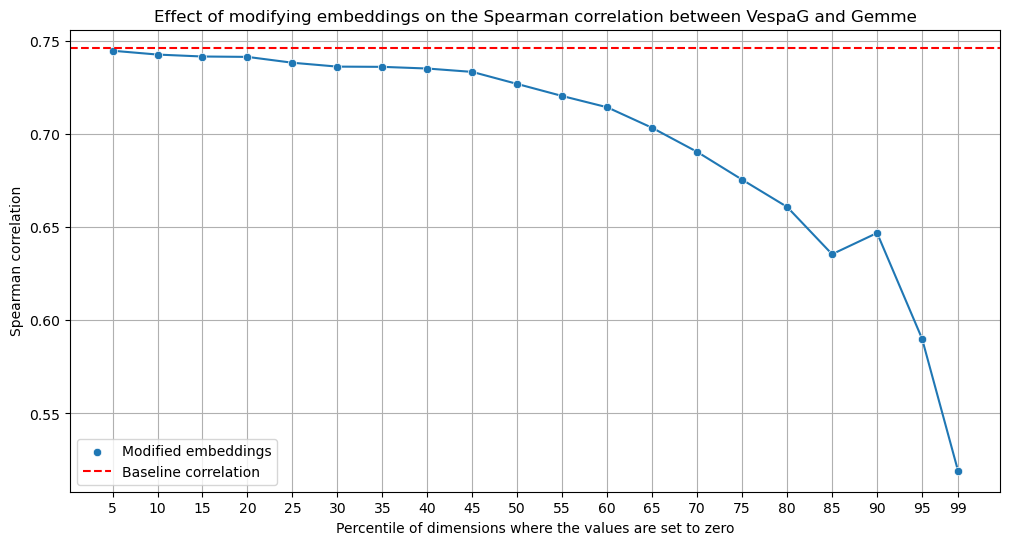

In [30]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=correlations_zero, x='percentile', y='spearman_correlation', zorder=2)
sns.scatterplot(data=correlations_zero, x='percentile', y='spearman_correlation', zorder=2, label='Modified embeddings')
plt.axhline(y=baseline_correlation, color='r', linestyle='--', label='Baseline correlation', zorder=2)
plt.xticks(correlations_zero['percentile'])
plt.title('Effect of modifying embeddings on the Spearman correlation between VespaG and Gemme')
plt.ylabel('Spearman correlation')
plt.xlabel('Percentile of dimensions where the values are set to zero')
plt.grid(zorder=0)
plt.legend()
plt.show()

In [31]:
percentile = 85
q = np.percentile(mean_saliency_per_dim, percentile)
np.where(mean_saliency_per_dim >= q)[0].shape

(384,)

In [32]:
correlations_zero.tail()

,percentile,modified_value,spearman_correlation
15,80,0,0.660941
16,85,0,0.635543
17,90,0,0.646947
18,95,0,0.590202
19,99,0,0.519232


In [33]:
baseline_correlation

0.7462097124809847

### Can we cluster these dimensions by amino acid properties 

If we can cluster these dimensions by amino acid properties, we can hypothesis that this is what the model is learning

In [34]:
# select the Dimensions in the 95th percentile
q = 85
threshold = np.percentile(mean_saliency_per_dim, q)
dimensions = np.where(mean_saliency_per_dim >= threshold)[0]
print(dimensions.shape) 
print(dimensions)

(384,)
[   4   17   26   39   43   45   53   65   66   72   85   99  101  105
  113  120  123  125  126  127  129  133  139  153  165  171  187  197
  207  214  219  228  231  238  244  250  252  261  267  272  280  295
  305  313  321  325  327  330  345  351  366  372  379  382  393  399
  404  406  427  431  438  439  452  454  457  458  461  478  483  496
  503  508  509  512  513  514  519  524  525  528  537  538  559  563
  582  591  607  612  623  626  628  633  636  641  649  650  658  659
  686  687  692  694  696  715  716  724  726  743  747  750  752  754
  755  765  766  769  771  782  797  803  804  805  808  810  820  822
  823  827  829  843  854  865  867  871  877  884  894  899  903  907
  908  912  915  920  934  951  955  969  984  991  996 1000 1005 1014
 1019 1030 1040 1042 1046 1050 1065 1070 1076 1078 1090 1095 1099 1101
 1116 1118 1128 1147 1154 1156 1164 1167 1171 1175 1176 1186 1187 1188
 1195 1197 1200 1202 1206 1213 1225 1237 1243 1282 1287 1289 1304 1309

In [36]:
proteingym_166_embedding_file = '/mnt/f/nicole/proteingym_166_vespag/esm2_embeddings.h5'

for q in [80, 85, 90, 95]:
    modified_embedding_file = f'/mnt/f/nicole/embeddings/proteingym_166_q{q}_dimensions.h5'
    threshold = np.percentile(mean_saliency_per_dim, q)
    dimensions = np.where(mean_saliency_per_dim >= threshold)[0]
    with h5py.File(proteingym_166_embedding_file, 'r') as f:
        # for each protein, select only the selected dimensions
        for protein_id in tqdm(f.keys(), desc="Processing proteins"):
            embedding = torch.tensor(f[protein_id][()])  
            modified_embedding = embedding[:, dimensions]

            # store the modified embedding
            with h5py.File(modified_embedding_file, 'a') as f_out:
                f_out.create_dataset(protein_id, data=modified_embedding.numpy())


Processing proteins:   0%|          | 0/166 [00:00<?, ?it/s]

Processing proteins: 100%|██████████| 166/166 [00:06<00:00, 24.71it/s]
